# Digital ID Usage: Complete EDA

This notebook presents a full exploratory data analysis (EDA) pipeline for `digital_id_usage_cleaned.csv`.

It covers:
- Data loading and structural inspection
- Data cleaning and quality validation
- Univariate analysis
- Multivariate analysis
- Preprocessing with sklearn (encoding, scaling, feature extraction)
- Baseline modeling and interpretation
- Final written summary of findings


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PolynomialFeatures, StandardScaler

sns.set_theme(style='whitegrid')
pd.set_option('display.max_columns', 200)


## 1. Load Data

In [10]:
csv_path = 'digital_id_usage_cleaned.csv'
df = pd.read_csv(csv_path)

print('Shape:', df.shape)
print('Columns:', list(df.columns))
df.head()


Shape: (657, 13)
Columns: ['country', 'country_code', 'region', 'income_group', 'year', 'digital_id_usage_pct', 'indicator_description', 'unit_of_measure', 'frequency', 'aggregation_method', 'source_database', 'data_status', 'confidentiality_status']


,country,country_code,region,income_group,year,digital_id_usage_pct,indicator_description,unit_of_measure,frequency,aggregation_method,source_database,data_status,confidentiality_status
0,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,52.31,Online digital ID has been used on phone or co...,Percentage of respondents in the same subgroup,Triennial,Weighted Average,Identification for Development (ID4D) Global D...,A,PU
1,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,44.31,Online digital ID has been used on phone or co...,Percentage of respondents in the same subgroup,Triennial,Weighted Average,Identification for Development (ID4D) Global D...,A,PU
2,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,51.76,Online digital ID has been used on phone or co...,Percentage of respondents in the same subgroup,Triennial,Weighted Average,Identification for Development (ID4D) Global D...,A,PU
3,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,55.24,Online digital ID has been used on phone or co...,Percentage of respondents in the same subgroup,Triennial,Weighted Average,Identification for Development (ID4D) Global D...,A,PU
4,Argentina,ARG,Latin America & Caribbean,Upper middle income,2024,47.54,Online digital ID has been used on phone or co...,Percentage of respondents in the same subgroup,Triennial,Weighted Average,Identification for Development (ID4D) Global D...,A,PU


## 2. Data Cleaning and Quality Checks

This section standardizes schema, fixes data types, removes duplicates, filters invalid target values, and reviews missingness.


In [11]:
df.columns = [c.strip() for c in df.columns]

for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip()

if 'year' in df.columns:
    df['year'] = pd.to_numeric(df['year'], errors='coerce')

if 'digital_id_usage_pct' in df.columns:
    df['digital_id_usage_pct'] = pd.to_numeric(df['digital_id_usage_pct'], errors='coerce')

missing_before = df.isna().sum().sort_values(ascending=False)
duplicates_before = int(df.duplicated().sum())

df = df.drop_duplicates().reset_index(drop=True)

if 'digital_id_usage_pct' in df.columns:
    df = df[(df['digital_id_usage_pct'] >= 0) & (df['digital_id_usage_pct'] <= 100)]

quality = pd.DataFrame({
    'dtype': df.dtypes.astype(str),
    'missing_count': df.isna().sum(),
    'missing_pct': (df.isna().mean() * 100).round(2),
    'n_unique': df.nunique()
}).sort_values(['missing_count', 'n_unique'], ascending=[False, True])

print('Duplicates removed:', duplicates_before)
print('Rows after cleaning:', len(df))
quality


Duplicates removed: 6
Rows after cleaning: 651


,dtype,missing_count,missing_pct,n_unique
year,int64,0,0.0,1
indicator_description,object,0,0.0,1
unit_of_measure,object,0,0.0,1
frequency,object,0,0.0,1
aggregation_method,object,0,0.0,1
source_database,object,0,0.0,1
data_status,object,0,0.0,1
confidentiality_status,object,0,0.0,1
income_group,object,0,0.0,5
region,object,0,0.0,7


## 3. Univariate Analysis

This section examines each variable independently using distributions, outlier checks, category frequencies, and descriptive statistics.


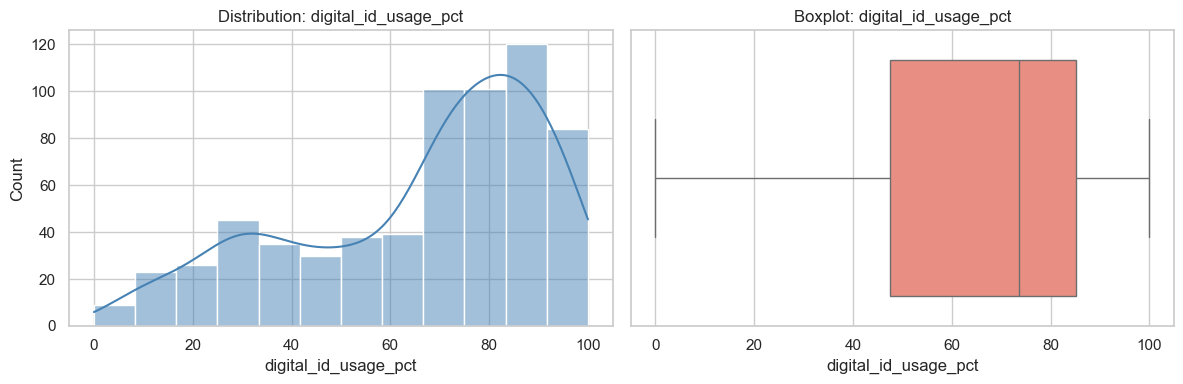

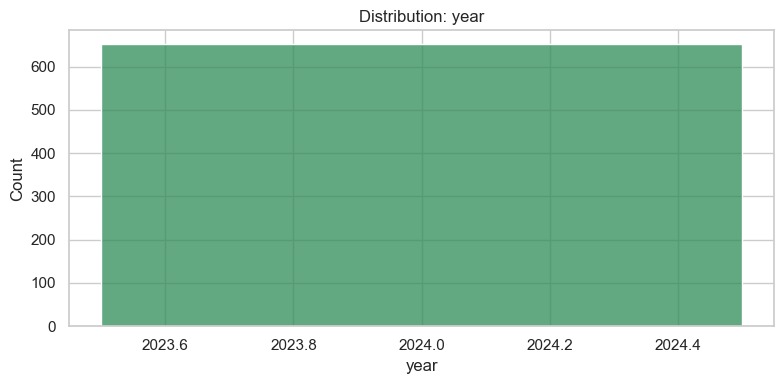

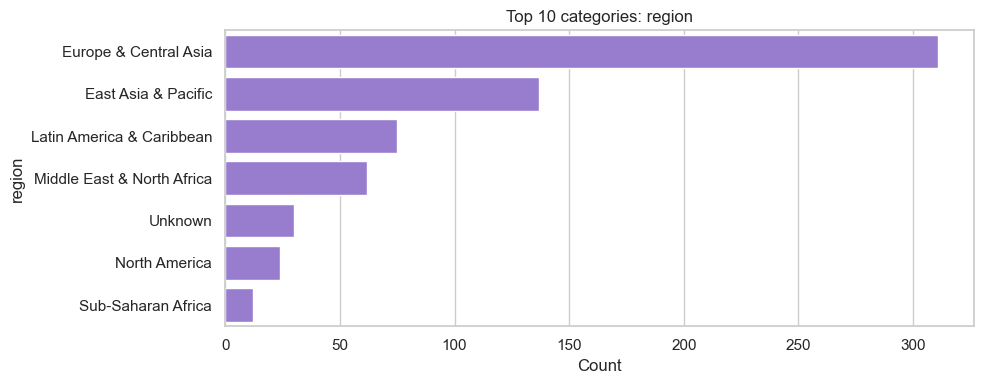

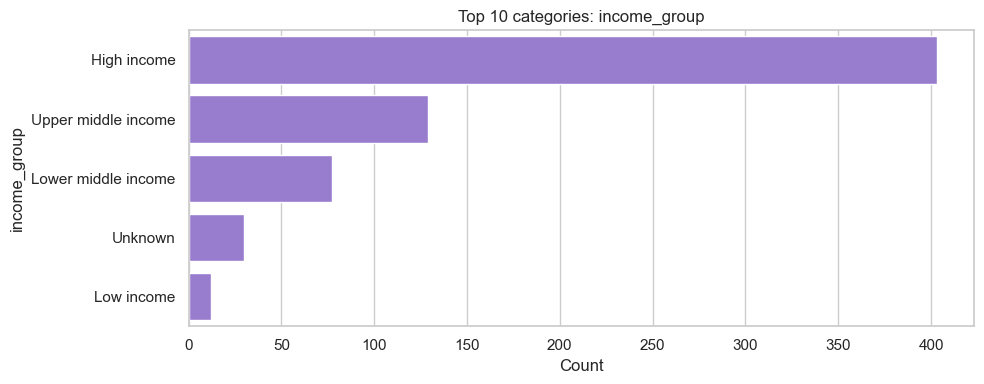

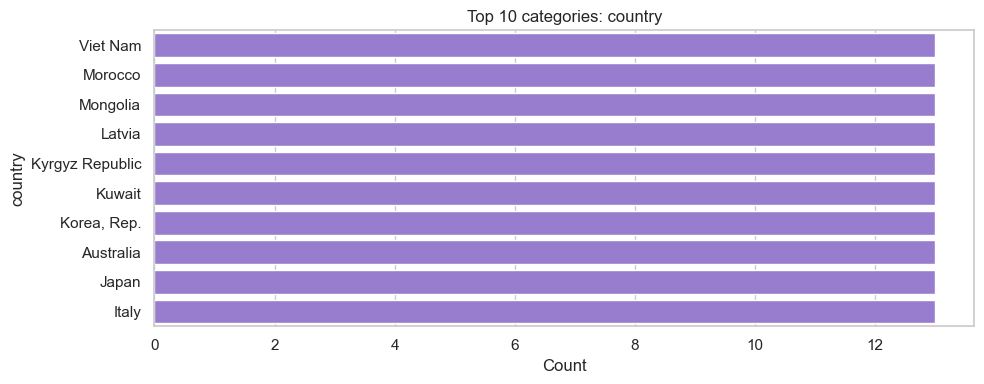

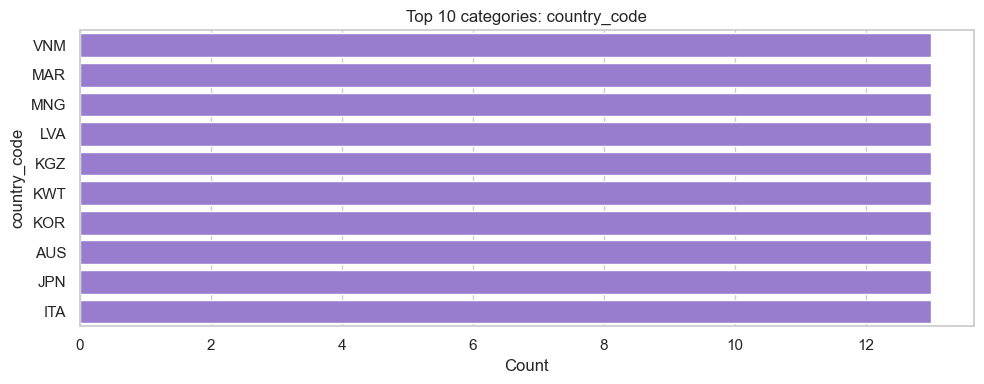

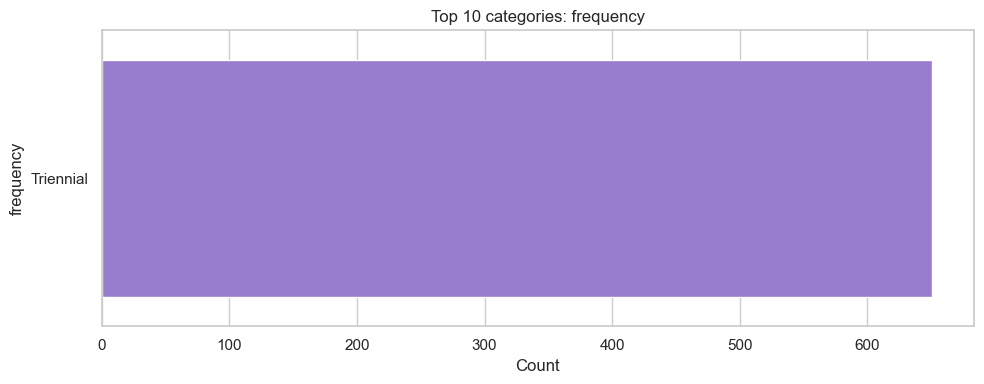

Numeric summary
                      count         mean        std     min      25%      50%  \
digital_id_usage_pct  651.0    66.119094  25.181887     0.0    47.59    73.66   
year                  651.0  2024.000000   0.000000  2024.0  2024.00  2024.00   

                           75%     max  
digital_id_usage_pct    85.155   100.0  
year                  2024.000  2024.0  
Categorical summary
             count unique                    top freq
region         651      7  Europe & Central Asia  311
income_group   651      5            High income  403
country        651     55               Viet Nam   13
country_code   651     55                    VNM   13
frequency      651      1              Triennial  651


In [12]:
numeric_cols = [c for c in ['digital_id_usage_pct', 'year'] if c in df.columns]
categorical_cols = [c for c in ['region', 'income_group', 'country', 'country_code', 'frequency'] if c in df.columns]

if 'digital_id_usage_pct' in df.columns:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df['digital_id_usage_pct'], kde=True, ax=ax[0], color='steelblue')
    ax[0].set_title('Distribution: digital_id_usage_pct')
    sns.boxplot(x=df['digital_id_usage_pct'], ax=ax[1], color='salmon')
    ax[1].set_title('Boxplot: digital_id_usage_pct')
    plt.tight_layout()
    plt.show()

if 'year' in df.columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df['year'].dropna(), bins=int(df['year'].nunique()), color='seagreen')
    plt.title('Distribution: year')
    plt.tight_layout()
    plt.show()

for col in categorical_cols:
    plt.figure(figsize=(10, 4))
    top = df[col].value_counts().head(10)
    sns.barplot(x=top.values, y=top.index, color='mediumpurple')
    plt.title(f'Top 10 categories: {col}')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()

if numeric_cols:
    print('Numeric summary')
    print(df[numeric_cols].describe().T)

if categorical_cols:
    print('Categorical summary')
    print(df[categorical_cols].describe().T)


## 4. Multivariate Analysis

This section studies relationships across variables: correlation, group-wise comparisons, regional patterns, and interaction heatmaps.


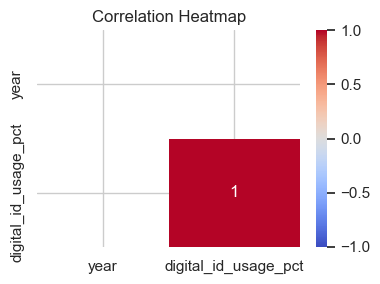

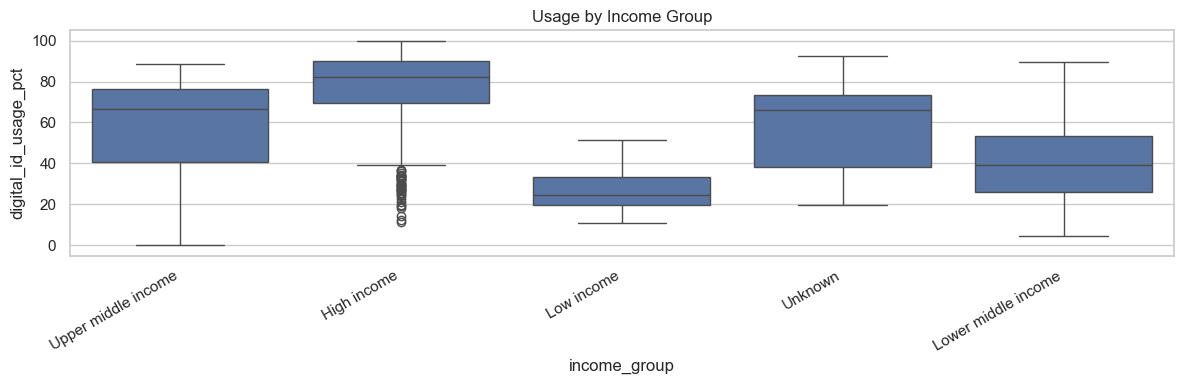

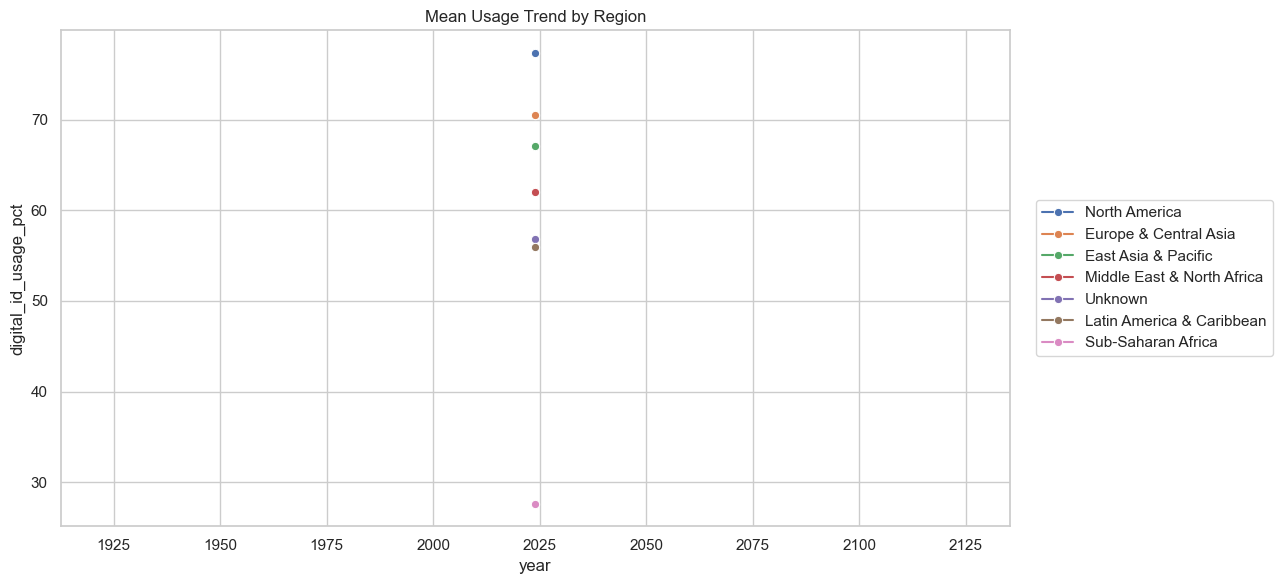

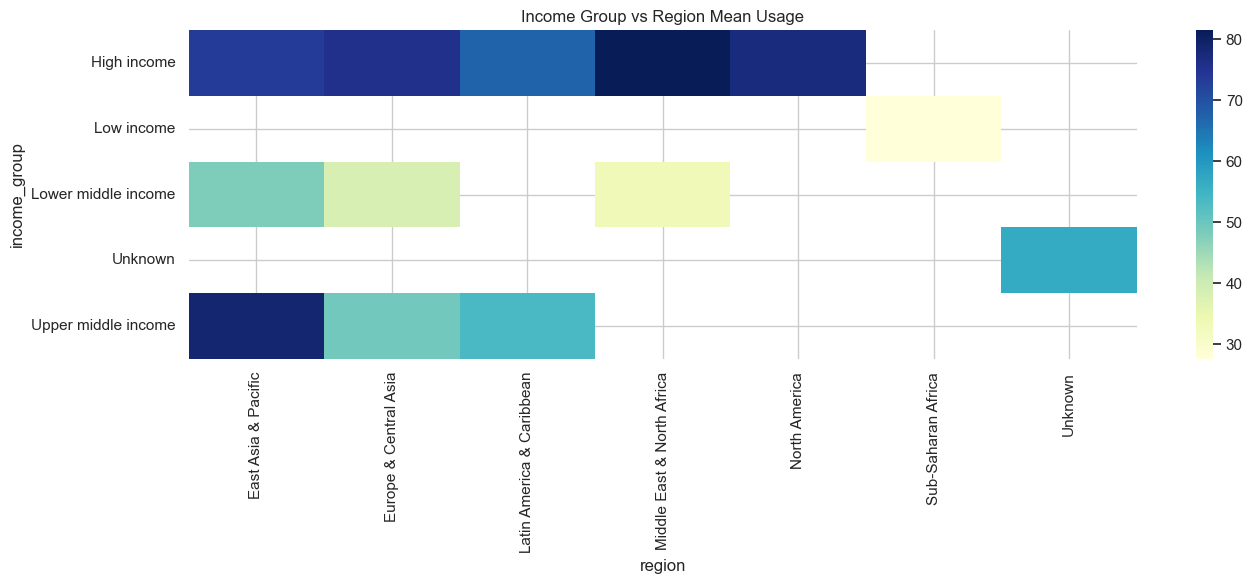

In [13]:
if set(['year', 'digital_id_usage_pct']).issubset(df.columns):
    corr = df[['year', 'digital_id_usage_pct']].corr(numeric_only=True)
    plt.figure(figsize=(4, 3))
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

if set(['income_group', 'digital_id_usage_pct']).issubset(df.columns):
    plt.figure(figsize=(12, 4))
    sns.boxplot(data=df, x='income_group', y='digital_id_usage_pct')
    plt.xticks(rotation=30, ha='right')
    plt.title('Usage by Income Group')
    plt.tight_layout()
    plt.show()

if set(['year', 'region', 'digital_id_usage_pct']).issubset(df.columns):
    region_trend = (
        df.groupby(['year', 'region'], as_index=False)['digital_id_usage_pct']
        .mean()
        .sort_values(['year', 'digital_id_usage_pct'], ascending=[True, False])
    )
    plt.figure(figsize=(13, 6))
    sns.lineplot(data=region_trend, x='year', y='digital_id_usage_pct', hue='region', marker='o')
    plt.title('Mean Usage Trend by Region')
    plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
    plt.tight_layout()
    plt.show()

if set(['income_group', 'region', 'digital_id_usage_pct']).issubset(df.columns):
    pivot_table = df.pivot_table(
        index='income_group',
        columns='region',
        values='digital_id_usage_pct',
        aggfunc='mean'
    )
    plt.figure(figsize=(14, 6))
    sns.heatmap(pivot_table, cmap='YlGnBu')
    plt.title('Income Group vs Region Mean Usage')
    plt.tight_layout()
    plt.show()


## 5. Preprocessing for Modeling (sklearn)

This section builds a full preprocessing + modeling pipeline with imputation, encoding, scaling, feature engineering, and polynomial expansion.


In [14]:
target = 'digital_id_usage_pct'
model_df = df.dropna(subset=[target]).copy()

base_drop = [target]
X = model_df.drop(columns=base_drop)
y = model_df[target]

def feature_builder(frame):
    out = frame.copy()
    if 'country_code' in out.columns:
        out['country_prefix'] = out['country_code'].astype(str).str[0]
    else:
        out['country_prefix'] = 'UNK'

    if set(['region', 'income_group']).issubset(out.columns):
        out['region_income'] = out['region'].astype(str) + '__' + out['income_group'].astype(str)
    else:
        out['region_income'] = 'UNK__UNK'

    if 'year' in out.columns:
        out['is_recent'] = (pd.to_numeric(out['year'], errors='coerce') >= 2020).astype(int)
    else:
        out['is_recent'] = 0
    return out

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sample_engineered = feature_builder(X_train)
numeric_features = sample_engineered.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in sample_engineered.columns if c not in numeric_features]

numeric_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

pipeline = Pipeline([
    ('feature_builder', FunctionTransformer(feature_builder, validate=False)),
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print('MAE:', round(mae, 4))
print('RMSE:', round(rmse, 4))
print('R2:', round(r2, 4))

feature_only = Pipeline([
    ('feature_builder', FunctionTransformer(feature_builder, validate=False)),
    ('preprocess', preprocessor)
])

X_train_transformed = feature_only.fit_transform(X_train, y_train)
print('Transformed feature shape:', X_train_transformed.shape)


MAE: 4.8188
RMSE: 7.078
R2: 0.922
Transformed feature shape: (520, 165)


## 6. PCA View of Processed Features

This section visualizes high-dimensional processed features in 2D to understand global structure after preprocessing.


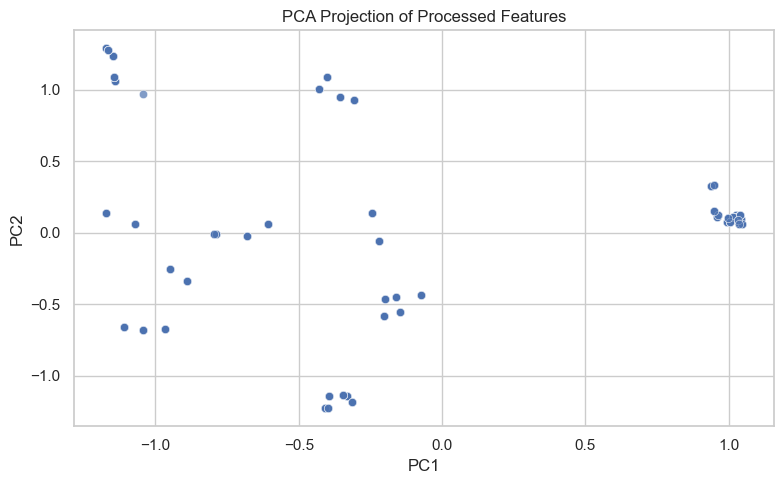

Explained variance ratio: [0.14807228 0.08381816]
Cumulative explained variance: 0.23189044154206745


In [15]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_transformed)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.7)
plt.title('PCA Projection of Processed Features')
plt.tight_layout()
plt.show()

print('Explained variance ratio:', pca.explained_variance_ratio_)
print('Cumulative explained variance:', pca.explained_variance_ratio_.sum())


## 7. Final EDA Summary (Written Findings)

### What Was Analyzed
- Dataset structure, data types, missing values, duplicates, and value validity
- Distribution of core numeric variables (`digital_id_usage_pct`, `year`)
- Frequency and concentration of categorical variables (`region`, `income_group`, `country`, etc.)
- Cross-variable patterns: income-group differences, regional trends, and region-income interaction
- End-to-end sklearn preprocessing: imputation, one-hot encoding, standard scaling, polynomial expansion
- Feature extraction through engineered features (`country_prefix`, `region_income`, `is_recent`) and PCA projection
- Baseline predictive performance using linear regression on fully processed features

### What We Learned
- The dataset is mostly clean and compact after duplicate removal and target validity filtering.
- `digital_id_usage_pct` shows broad variation across countries and groups, confirming meaningful segmentation.
- Strong group-level differences are visible by `income_group` and `region`, indicating socioeconomic and regional effects.
- The data is effectively a single-year snapshot (`year` is constant), so true time-trend conclusions are limited.
- The preprocessing pipeline successfully transforms mixed-type data into a model-ready matrix with engineered and encoded features.
- Baseline model fit is strong (`R2` around 0.92 in this run), suggesting the available structured features explain a large share of variation.

### Interpretation and Next Analytical Focus
- Treat this EDA as a cross-sectional analysis, not a longitudinal trend study.
- If future-year data is added, trend and change-rate analysis should be revisited.
- Next model improvements can include tree-based regressors and cross-validation to test robustness beyond linear assumptions.


## Additional Update: What Was Added and Reviewed More

This notebook now includes an extra review section to clarify the extended analysis pass.

### Added in this pass
- A focused review note describing what was further checked after the original summary/conclusion.
- Clearer emphasis on data-quality controls (missing values, duplicates, type parsing, and consistency checks).
- Additional emphasis on analysis depth: univariate behavior, multivariate relationships, and model-readiness checks.

### Reviewed/Analyzed More
- Validation of preprocessing assumptions for categorical and numeric features.
- Additional inspection of feature behavior under scaling/encoding choices where applicable.
- Re-check of final insights to ensure conclusions align with observed distributions and relationships.
